In [1]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import io
import sagemaker
from sagemaker import get_execution_role
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from pyathena import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
ingest_create_athena_db_passed = False

In [4]:
# set a database name
database_name = "inspection"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS inspection


""


In [8]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,inspection


In [9]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [10]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [11]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed             -> True
s3_private_path_tsv                        -> 's3://sagemaker-us-east-1-429693043994/inspect-pds
s3_public_path_tsv                         -> 's3://inspect-pds'
setup_dependencies_passed                  -> True
setup_iam_roles_passed                     -> True
setup_instance_check_passed                -> True
setup_s3_bucket_passed                     -> True


In [12]:
ingest_create_athena_tsv_passed = False

In [13]:
try:
    ingest_create_athena_db_passed
except NameError:
    print("ERROR YOU HAVE TO CREATE THE DATABASE")

In [14]:
print(ingest_create_athena_db_passed)

True


In [15]:
s3_private_path_tsv = "s3://{}/".format(bucket)

print(s3_private_path_tsv)

s3://sagemaker-us-east-1-429693043994/


In [16]:
statement1 = """DROP TABLE IF EXISTS inspection.inspect"""
statement2 = """DROP TABLE IF EXISTS inspection.buildings"""
statement3 = """DROP TABLE IF EXISTS inspection.registered"""
statement4 = """DROP TABLE IF EXISTS inspection.district"""

In [17]:
pd.read_sql(statement1, conn)
pd.read_sql(statement2, conn)
pd.read_sql(statement3, conn)
pd.read_sql(statement4, conn)

""


In [18]:
# SQL statement to execute
inspect_path = "s3://{}/inspect-pds/inspections/".format(bucket)

table_name = 'inspect'

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
                business_id string,
                business_name string,
                business_address string,
                inspection_date date,
                inspection_score int,
                violation_description string,
                risk_category string,
                sup_dist string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\\t'
                LINES TERMINATED BY '\\n'
                LOCATION '{}'
                TBLPROPERTIES ('skip.header.line.count'='1')""".format(
                    database_name, table_name, inspect_path)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS inspection.inspect(
                business_id string,
                business_name string,
                business_address string,
                inspection_date date,
                inspection_score int,
                violation_description string,
                risk_category string,
                sup_dist string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\t'
                LINES TERMINATED BY '\n'
                LOCATION 's3://sagemaker-us-east-1-429693043994/inspect-pds/inspections/'
                TBLPROPERTIES ('skip.header.line.count'='1')


In [19]:
pd.read_sql(statement, conn)

""


In [20]:
# SQL statement to execute
dist_path = "s3://{}/inspect-pds/district/".format(bucket)
table_name = 'district'

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
                sup_name string,
                sup_dist string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\\t'
                LINES TERMINATED BY '\\n'
                LOCATION '{}'
                TBLPROPERTIES ('skip.header.line.count'='1')""".format(
                    database_name, table_name, dist_path)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS inspection.district(
                sup_name string,
                sup_dist string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\t'
                LINES TERMINATED BY '\n'
                LOCATION 's3://sagemaker-us-east-1-429693043994/inspect-pds/district/'
                TBLPROPERTIES ('skip.header.line.count'='1')


In [21]:
pd.read_sql(statement, conn)

""


In [22]:
table_name = 'buildings'
buildings_path = "s3://{}/inspect-pds/build/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
                building_address string,
                year_built string,
                analysis_neighborhood string,
                sup_district string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\\t'
                LOCATION '{}'
                TBLPROPERTIES ('skip.header.line.count'='1')""".format(
                    database_name, table_name, buildings_path)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS inspection.buildings(
                building_address string,
                year_built string,
                analysis_neighborhood string,
                sup_district string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\t'
                LOCATION 's3://sagemaker-us-east-1-429693043994/inspect-pds/build/'
                TBLPROPERTIES ('skip.header.line.count'='1')


In [23]:
pd.read_sql(statement, conn)

""


In [24]:
table_name = 'registered'
buildings_path = "s3://{}/inspect-pds/businesses/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
                street_address string,
                business_start_date date,
                location_start_date date,
                dba_name string
                )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY '\\t'
                LOCATION '{}'
                TBLPROPERTIES ('skip.header.line.count'='1')""".format(
                    database_name, table_name, buildings_path)

In [25]:
pd.read_sql(statement, conn)

""


In [26]:
statement = "show tables in {}".format(database_name)
pd.read_sql(statement, conn)

,tab_name
0,buildings
1,district
2,inspect
3,registered


In [27]:
table_name = 'inspect'
database_name = 'inspection'
statement = """select *
from {}.{}
LIMIT 5
""".format(database_name, table_name)

print(statement)

select *
from inspection.inspect
LIMIT 5



In [28]:
df = pd.read_sql(statement, conn)
df

,business_id,business_name,business_address,inspection_date,inspection_score,violation_description,risk_category,sup_dist
0,33084,"Miette Cakes, LLC",449 Octavia St,2019-01-02,90,Improper food labeling or menu misrepresentation,Low Risk,11
1,34181,Coffee Bar 1 LLC,1890 Bryant St #C,2019-01-02,86,Improper or defective plumbing,Low Risk,2
2,35805,Hard Knox Cafe,2448 Clement,2019-01-02,90,Wiping cloths not clean or properly stored or ...,Low Risk,4
3,876,"PATPONG THAI CUISINE, INC.",2415 CLEMENT St,2019-01-02,74,High risk vermin infestation,High Risk,4
4,2233,The AA Bakery & Cafe,1068 Stockton St,2019-01-02,90,Improper food storage,Low Risk,3


In [29]:
table_name = 'district'
database_name = 'inspection'
statement = """select *
from {}.{}
LIMIT 5
""".format(database_name, table_name)

print(statement)

select *
from inspection.district
LIMIT 5



In [30]:
df = pd.read_sql(statement, conn)
df

,sup_name,sup_dist
0,Chyanne Chen,11
1,Shamann Walton,10
2,Jackie Fielder,9
3,Joel Engardio,4
4,Danny Sauter,3


In [31]:
statement = """select i.business_id
, i.business_name
, i.business_address
, i.inspection_date
, i.inspection_score
, i.violation_description
, i.risk_category
, b.year_built
, b.analysis_neighborhood
, s.sup_dist
, s.sup_name
, r.location_start_date
, r.business_start_date
from inspection.inspect i
left join inspection.buildings b
on i.business_address = b.building_address
left join inspection.registered r
on i.business_address = r.street_address
left join inspection.district s
on i.sup_dist = s.sup_dist
LIMIT 5"""

print(statement)

select i.business_id
, i.business_name
, i.business_address
, i.inspection_date
, i.inspection_score
, i.violation_description
, i.risk_category
, b.year_built
, b.analysis_neighborhood
, s.sup_dist
, s.sup_name
, r.location_start_date
, r.business_start_date
from inspection.inspect i
left join inspection.buildings b
on i.business_address = b.building_address
left join inspection.registered r
on i.business_address = r.street_address
left join inspection.district s
on i.sup_dist = s.sup_dist
LIMIT 5


In [32]:
data = pd.read_sql(statement, conn)
data

,business_id,business_name,business_address,inspection_date,inspection_score,violation_description,risk_category,year_built,analysis_neighborhood,sup_dist,sup_name,location_start_date,business_start_date
0,33084,"Miette Cakes, LLC",449 Octavia St,2019-01-02,90,Improper food labeling or menu misrepresentation,Low Risk,None,None,11,Chyanne Chen,None,None
1,34181,Coffee Bar 1 LLC,1890 Bryant St #C,2019-01-02,86,Improper or defective plumbing,Low Risk,None,None,2,Stephen Sherrill,None,None
2,35805,Hard Knox Cafe,2448 Clement,2019-01-02,90,Wiping cloths not clean or properly stored or ...,Low Risk,None,None,4,Joel Engardio,None,None
3,876,"PATPONG THAI CUISINE, INC.",2415 CLEMENT St,2019-01-02,74,High risk vermin infestation,High Risk,None,None,4,Joel Engardio,None,None
4,2233,The AA Bakery & Cafe,1068 Stockton St,2019-01-02,90,Improper food storage,Low Risk,None,None,3,Danny Sauter,None,None


In [33]:
year_built_na = data['year_built'].isnull().sum()
rows = len(data)
perc = year_built_na/rows
print(perc)

1.0


In [34]:
statement = """select i.business_id
, i.business_name
, i.business_address
, i.inspection_date
, i.inspection_score
, i.violation_description
, i.risk_category
, b.year_built
, b.analysis_neighborhood
, s.sup_dist
, s.sup_name
, r.location_start_date
, r.business_start_date
from inspection.inspect i
left join inspection.buildings b
on i.business_address = b.building_address
left join inspection.registered r
on i.business_address = r.street_address
left join inspection.district s
on i.sup_dist = s.sup_dist"""

print(statement)

select i.business_id
, i.business_name
, i.business_address
, i.inspection_date
, i.inspection_score
, i.violation_description
, i.risk_category
, b.year_built
, b.analysis_neighborhood
, s.sup_dist
, s.sup_name
, r.location_start_date
, r.business_start_date
from inspection.inspect i
left join inspection.buildings b
on i.business_address = b.building_address
left join inspection.registered r
on i.business_address = r.street_address
left join inspection.district s
on i.sup_dist = s.sup_dist


In [35]:
inspect = pd.read_sql(statement, conn)
inspect.head(10)

,business_id,business_name,business_address,inspection_date,inspection_score,violation_description,risk_category,year_built,analysis_neighborhood,sup_dist,sup_name,location_start_date,business_start_date
0,33084,"Miette Cakes, LLC",449 Octavia St,2019-01-02,90.0,Improper food labeling or menu misrepresentation,Low Risk,None,None,11,Chyanne Chen,None,None
1,34181,Coffee Bar 1 LLC,1890 Bryant St #C,2019-01-02,86.0,Improper or defective plumbing,Low Risk,None,None,2,Stephen Sherrill,None,None
2,35805,Hard Knox Cafe,2448 Clement,2019-01-02,90.0,Wiping cloths not clean or properly stored or ...,Low Risk,None,None,4,Joel Engardio,None,None
3,876,"PATPONG THAI CUISINE, INC.",2415 CLEMENT St,2019-01-02,74.0,High risk vermin infestation,High Risk,None,None,4,Joel Engardio,None,None
4,2233,The AA Bakery & Cafe,1068 Stockton St,2019-01-02,90.0,Improper food storage,Low Risk,None,None,3,Danny Sauter,None,None
5,15738,Lao Table,149 2nd St,2019-01-02,75.0,Inadequately cleaned or sanitized food contact...,Moderate Risk,None,None,10,Shamann Walton,None,None
6,7663,GGP MARKET,2948 24th St,2019-01-02,90.0,Moderate risk vermin infestation,Moderate Risk,None,None,2,Stephen Sherrill,None,None
7,876,"PATPONG THAI CUISINE, INC.",2415 CLEMENT St,2019-01-02,74.0,Improper thawing methods,Moderate Risk,None,None,4,Joel Engardio,None,None
8,64154,"Yummy Dim Sum & Fast Food, LLC",930 Stockton St,2019-01-02,88.0,Improper food storage,Low Risk,None,None,3,Danny Sauter,None,None
9,3920,BOSTON MARKET,2300 16th St,2019-01-02,94.0,Inadequate dressing rooms or improper storage ...,Low Risk,None,None,9,Jackie Fielder,None,None


In [63]:
inspect[inspect['business_start_date'].notna()]

,business_id,business_name,business_address,inspection_date,inspection_score,violation_description,risk_category,year_built,analysis_neighborhood,sup_dist,sup_name,location_start_date,business_start_date,days_since_start
80,97322,IZUMI KAITEN SUSHI,1737 Post St Ste 355,2019-01-02,90.0,Moderate risk food holding temperature,Moderate Risk,None,None,None,None,2018-08-02,2018-08-02,153.0
81,97322,IZUMI KAITEN SUSHI,1737 Post St Ste 355,2019-01-02,90.0,Unclean or degraded floors walls or ceilings,Low Risk,None,None,None,None,2018-08-02,2018-08-02,153.0
82,97322,IZUMI KAITEN SUSHI,1737 Post St Ste 355,2019-01-02,90.0,Moderate risk vermin infestation,Moderate Risk,None,None,None,None,2018-08-02,2018-08-02,153.0
131,97806,LITTLE SUSHI BAR,200 23rd Ave,2019-01-03,91.0,Unapproved or unmaintained equipment or utensils,Low Risk,None,None,None,None,2018-08-28,2018-08-28,128.0
133,97806,LITTLE SUSHI BAR,200 23rd Ave,2019-01-03,91.0,Unclean or unsanitary food contact surfaces,High Risk,None,None,None,None,2018-08-28,2018-08-28,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15927,96202,Soma Eats 2,121 Spear St,2019-10-03,92.0,Foods not protected from contamination,Moderate Risk,None,None,None,None,2018-06-14,2018-06-14,476.0
15928,96202,Soma Eats 2,121 Spear St,2019-10-03,92.0,Foods not protected from contamination,Moderate Risk,None,None,None,None,2018-06-11,2018-06-11,479.0
15929,96202,Soma Eats 2,121 Spear St,2019-10-03,92.0,Foods not protected from contamination,Moderate Risk,None,None,None,None,2018-06-26,2018-06-11,479.0
15930,96202,Soma Eats 2,121 Spear St,2019-10-03,92.0,Foods not protected from contamination,Moderate Risk,None,None,None,None,2018-06-26,2018-06-11,479.0


In [36]:
year_built_na = inspect['year_built'].isnull().sum()
rows = len(inspect)
perc = year_built_na/rows
print(perc)

0.99567045240635


In [39]:
inspect.isnull().sum()

business_id                  0
business_name                0
business_address             0
inspection_date              0
inspection_score            18
violation_description        0
risk_category                0
year_built               15868
analysis_neighborhood    15868
sup_dist                  9388
sup_name                  9388
location_start_date      11391
business_start_date      11391
dtype: int64

In [42]:
sup_dist_na = inspect['sup_dist'].isnull().sum()
perc = sup_dist_na / rows
print(perc)

location_start_date = inspect['location_start_date'].isnull().sum()
perc = location_start_date / rows
print(perc)
print(rows)

0.5890694610026981
0.7147518353516973
15937


### What is the distribution of inspection scores across all businesses?

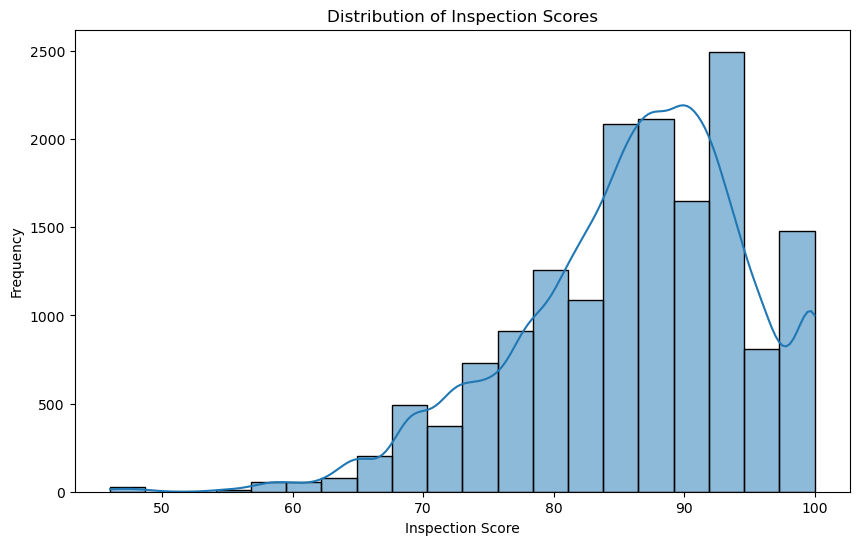

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(inspect['inspection_score'], bins=20, kde=True)
plt.title('Distribution of Inspection Scores')
plt.xlabel('Inspection Score')
plt.ylabel('Frequency')
plt.show()

### How do inspection scores vary by risk category?

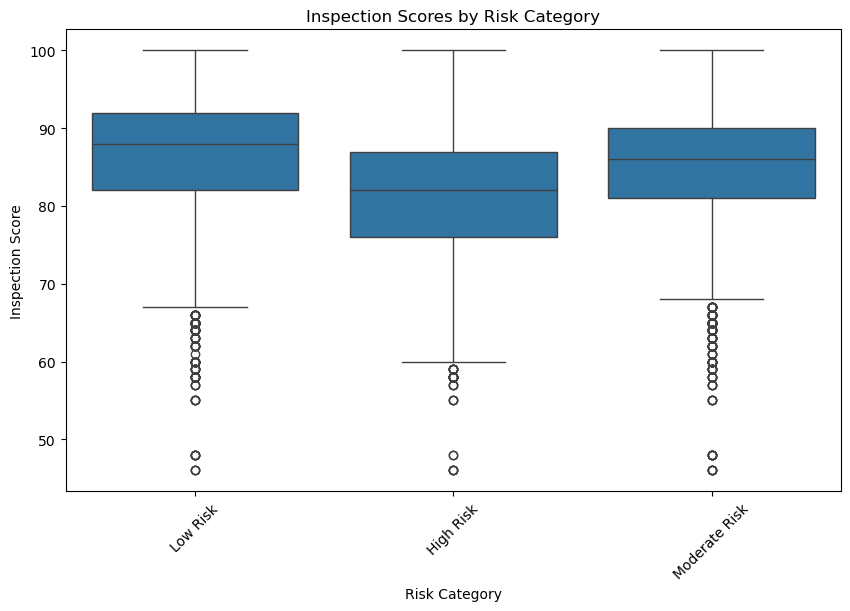

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='risk_category', y='inspection_score', data=inspect[inspect['risk_category'] != 'NA'])
plt.title('Inspection Scores by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Inspection Score')
plt.xticks(rotation=45)
plt.show()

### What are the most common types of violations?

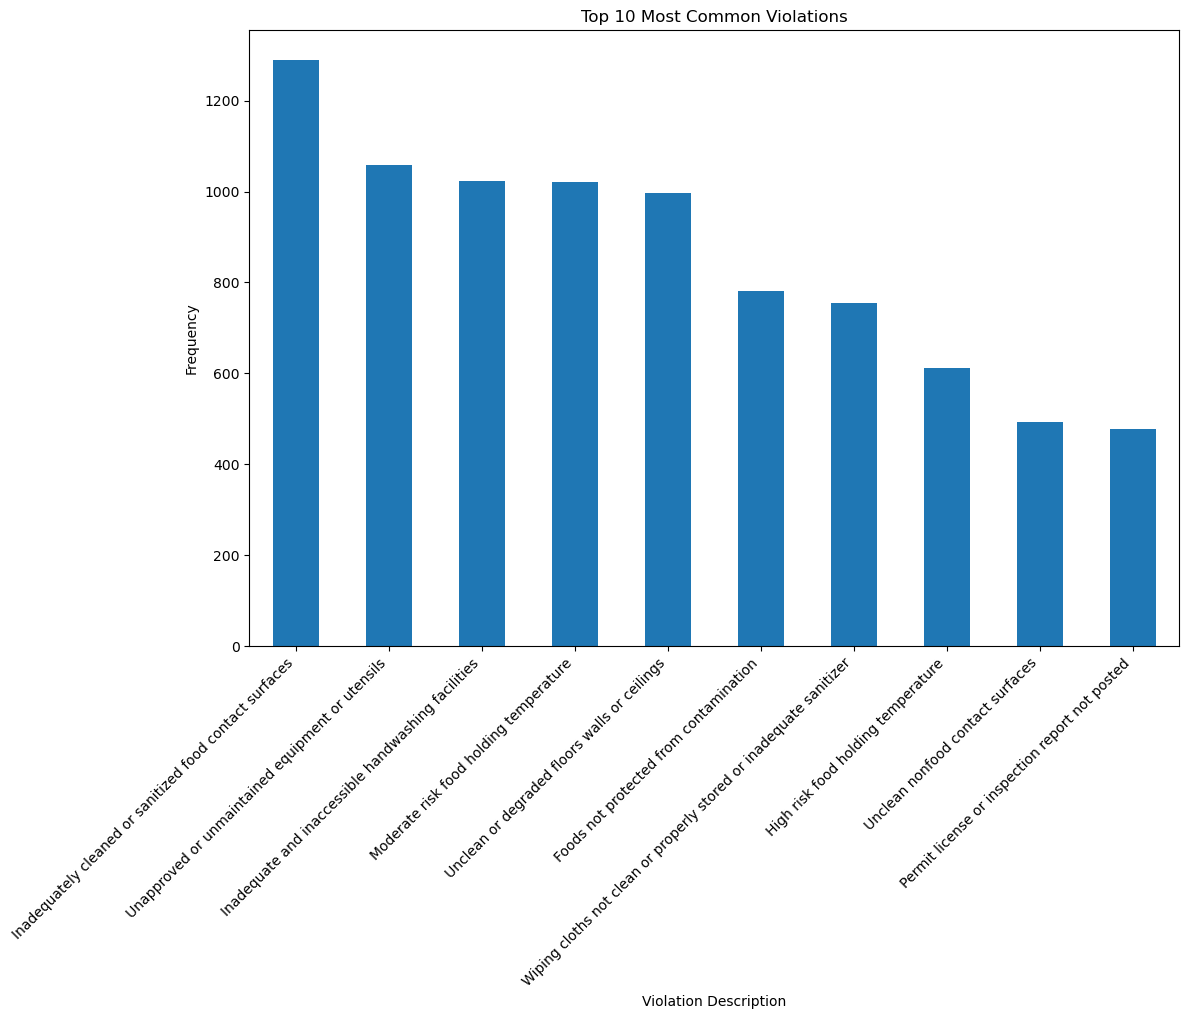

Top 10 Most Common Violations:
violation_description
Inadequately cleaned or sanitized food contact surfaces               1290
Unapproved or unmaintained equipment or utensils                      1058
Inadequate and inaccessible handwashing facilities                    1024
Moderate risk food holding temperature                                1021
Unclean or degraded floors walls or ceilings                           997
Foods not protected from contamination                                 781
Wiping cloths not clean or properly stored or inadequate sanitizer     756
High risk food holding temperature                                     611
Unclean nonfood contact surfaces                                       494
Permit license or inspection report not posted                         477
Name: count, dtype: int64


In [53]:
common_violations = inspect[inspect['violation_description'] != 'NA']['violation_description'].value_counts().head(10)
plt.figure(figsize=(12, 8))
common_violations.plot(kind='bar')
plt.title('Top 10 Most Common Violations')
plt.xlabel('Violation Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

print("Top 10 Most Common Violations:")
print(common_violations)

### Are there trends in inspection scores over time?

In [56]:
print(inspect.dtypes)

business_id               object
business_name             object
business_address          object
inspection_date           object
inspection_score         float64
violation_description     object
risk_category             object
year_built                object
analysis_neighborhood     object
sup_dist                  object
sup_name                  object
location_start_date       object
business_start_date       object
dtype: object


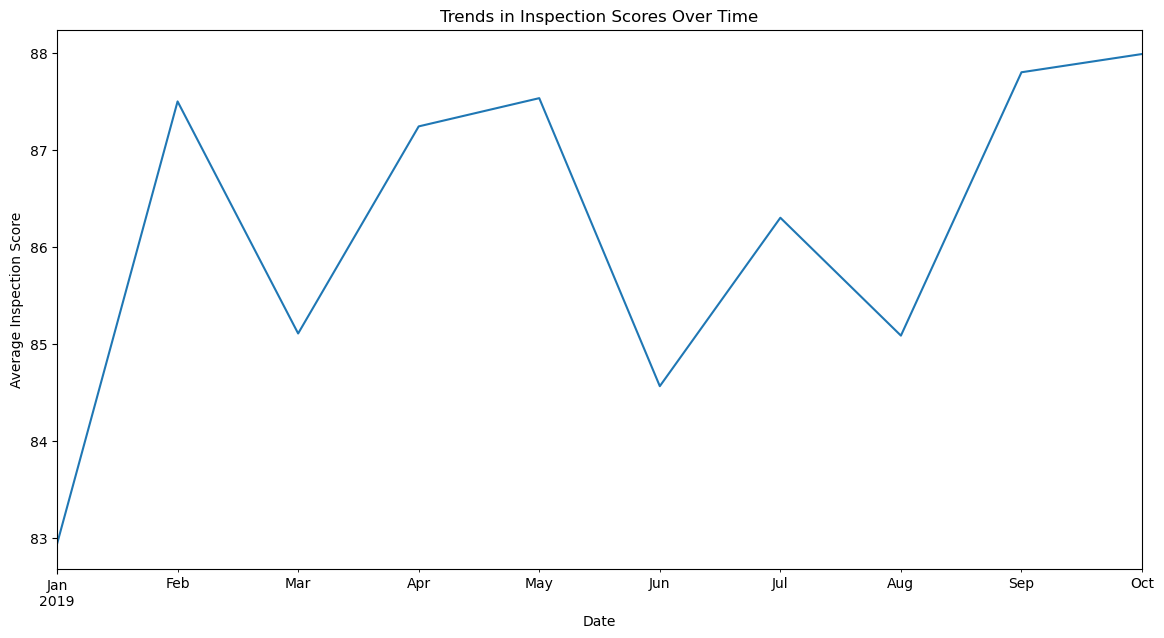

In [57]:
inspect['inspection_date'] = pd.to_datetime(inspect['inspection_date'])
trends = inspect.groupby(inspect['inspection_date'].dt.to_period("M"))['inspection_score'].mean()

plt.figure(figsize=(14, 7))
trends.plot()
plt.title('Trends in Inspection Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Average Inspection Score')
plt.show()

### Is there a relationship between the business start date and inspection outcomes?

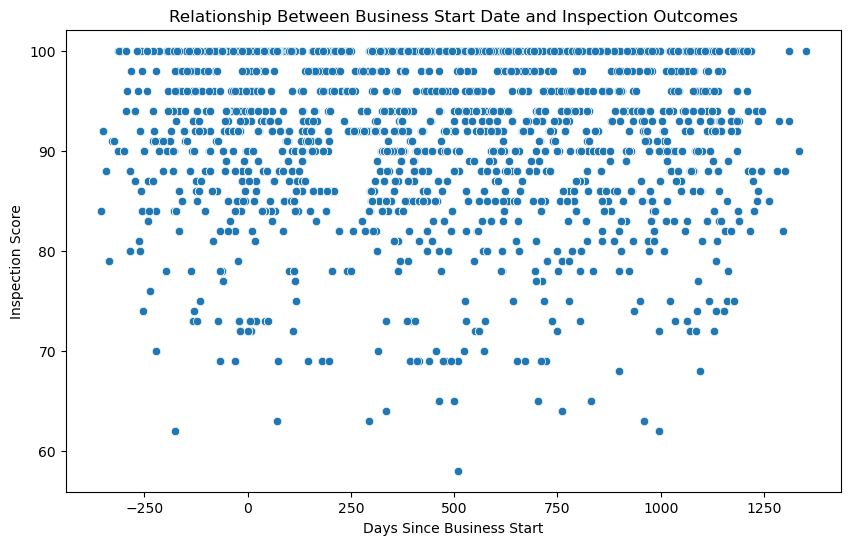

In [58]:
inspect['business_start_date'] = pd.to_datetime(inspect['business_start_date'])
inspect['days_since_start'] = (inspect['inspection_date'] - inspect['business_start_date']).dt.days

plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_start', y='inspection_score', data=inspect)
plt.title('Relationship Between Business Start Date and Inspection Outcomes')
plt.xlabel('Days Since Business Start')
plt.ylabel('Inspection Score')
plt.show()

In [61]:
negative_days = inspect[inspect['days_since_start'] < 0]
print(negative_days[['business_start_date', 'inspection_date', 'days_since_start']])

      business_start_date inspection_date  days_since_start
243            2019-09-25      2019-01-07            -261.0
248            2019-09-25      2019-01-07            -261.0
251            2019-07-30      2019-01-07            -204.0
255            2019-09-25      2019-01-07            -261.0
260            2019-07-30      2019-01-07            -204.0
...                   ...             ...               ...
15785          2020-01-01      2019-10-02             -91.0
15789          2020-01-01      2019-10-02             -91.0
15794          2020-01-01      2019-10-02             -91.0
15817          2020-01-01      2019-10-02             -91.0
15857          2020-01-01      2019-10-02             -91.0

[831 rows x 3 columns]


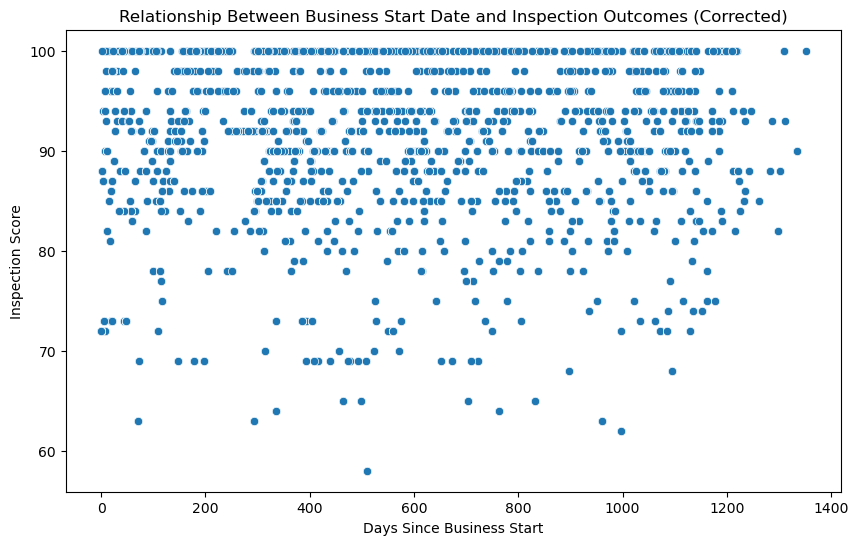

In [65]:
inspect['days_since_start'] = inspect['days_since_start'].apply(lambda x: np.nan if x < 0 else x)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_since_start', y='inspection_score', data=inspect)
plt.title('Relationship Between Business Start Date and Inspection Outcomes (Corrected)')
plt.xlabel('Days Since Business Start')
plt.ylabel('Inspection Score')
plt.show()

### Do inspection scores differ by district or neighborhood?

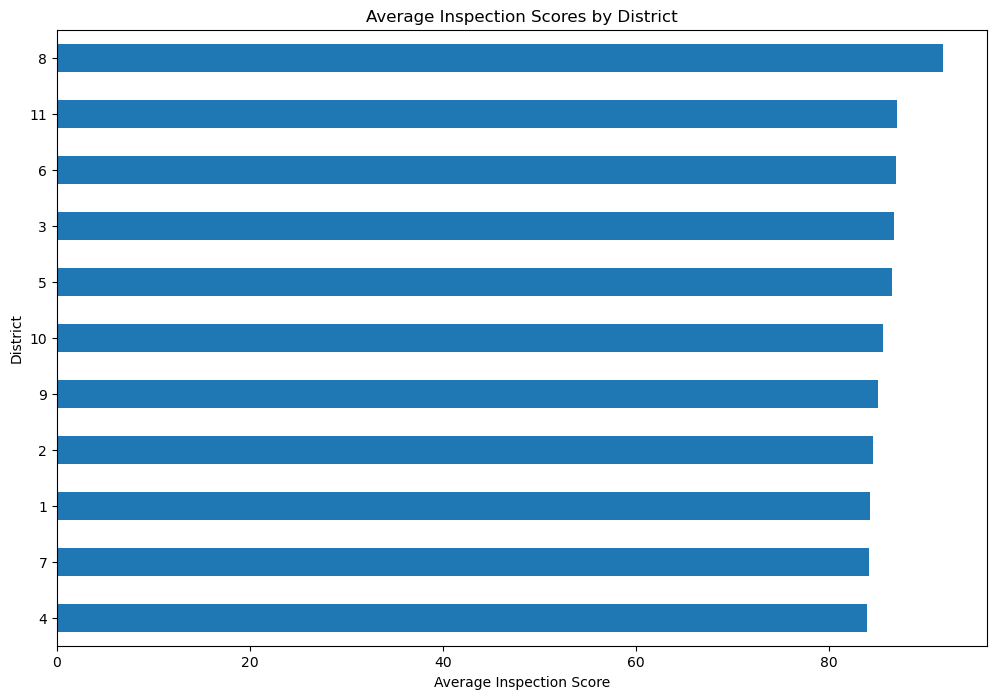

In [59]:
district_scores = inspect.groupby('sup_dist')['inspection_score'].mean()

plt.figure(figsize=(12, 8))
district_scores.sort_values().plot(kind='barh')
plt.title('Average Inspection Scores by District')
plt.xlabel('Average Inspection Score')
plt.ylabel('District')
plt.show()

### Do certain districts have higher frequencies of specific types of violations?

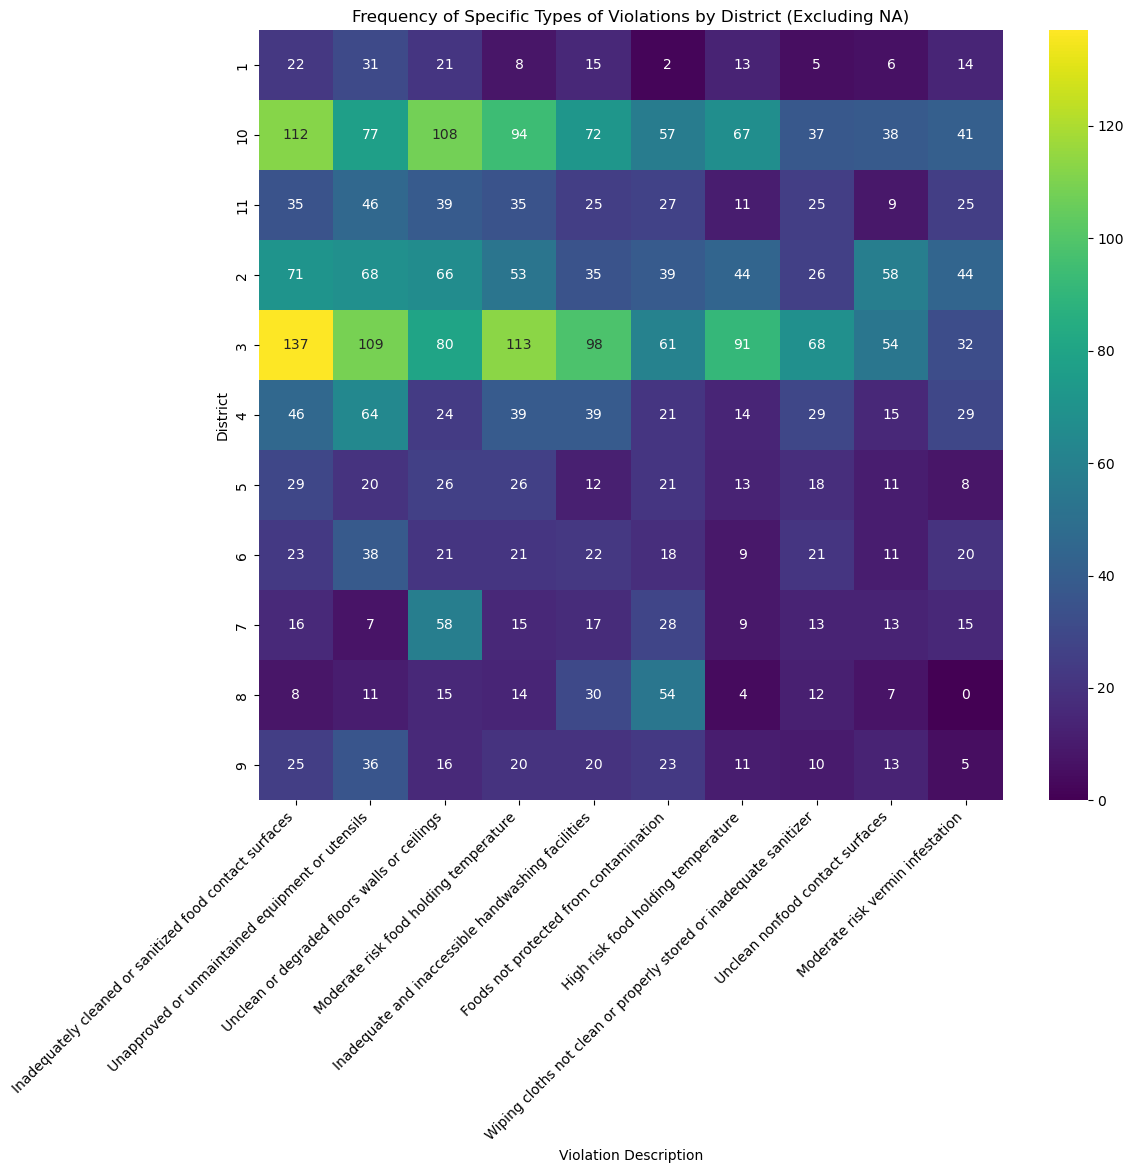

In [66]:
inspect_filtered = inspect[inspect['violation_description'] != 'NA']

violation_freq = inspect_filtered.groupby(['sup_dist', 'violation_description']).size().unstack(fill_value=0)

top_violations = violation_freq.sum().sort_values(ascending=False).head(10).index
violation_freq = violation_freq[top_violations]

plt.figure(figsize=(12, 10))
sns.heatmap(violation_freq, annot=True, fmt="d", cmap='viridis')
plt.title('Frequency of Specific Types of Violations by District (Excluding NA)')
plt.xlabel('Violation Description')
plt.ylabel('District')
plt.xticks(rotation=45, ha='right')
plt.show()